# Generate Synthetic Lightcurves for Input

In [40]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

# Import functions
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import os

import eigenspectra
from eigenspectra import gen_lightcurves, plot_utils

In [41]:
# Use prettier plot defaults 
plot_utils.plot_setup()

In [46]:
# Get wavelength-dependent healpix map
lamhr, spaxels = gen_lightcurves.prep_spectral_hotspot_map(Nside=32)

# Let's inspect the shapes of these two arrays
lamhr.shape, spaxels.shape

((417,), (12288, 417))

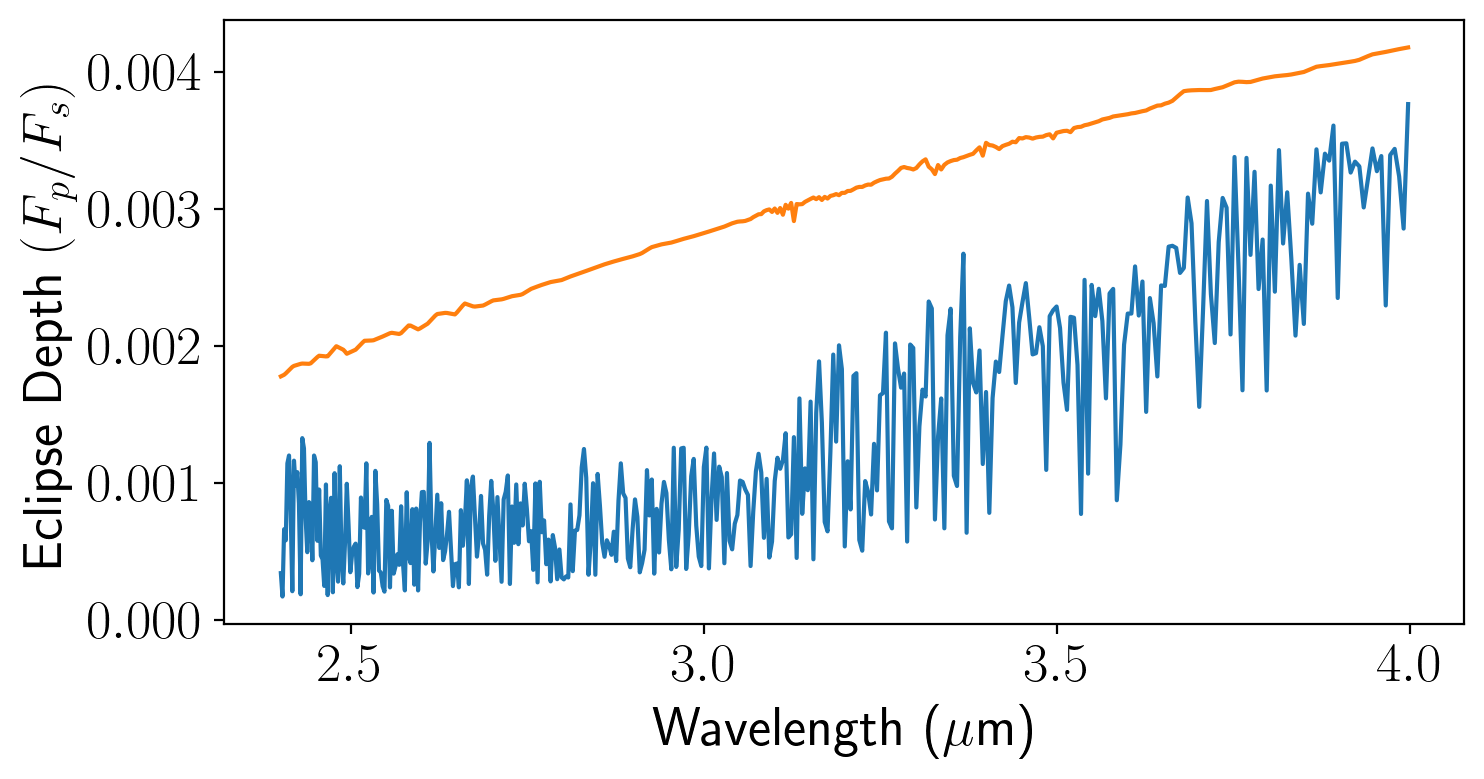

In [48]:
# Find the index of the spectrum inside and outside the hotspot (cheap hack for this map case)
imin = np.argmin(np.sum(spaxels, axis=1))
imax = np.argmax(np.sum(spaxels, axis=1))

fig, ax = plt.subplots(figsize = (8,4))
ax.set_xlabel("Wavelength ($\mu$m)")
ax.set_ylabel("Eclipse Depth $(F_p / F_s)$")
ax.plot(lamhr, spaxels.T[:,imin]);
ax.plot(lamhr, spaxels.T[:,imax]);

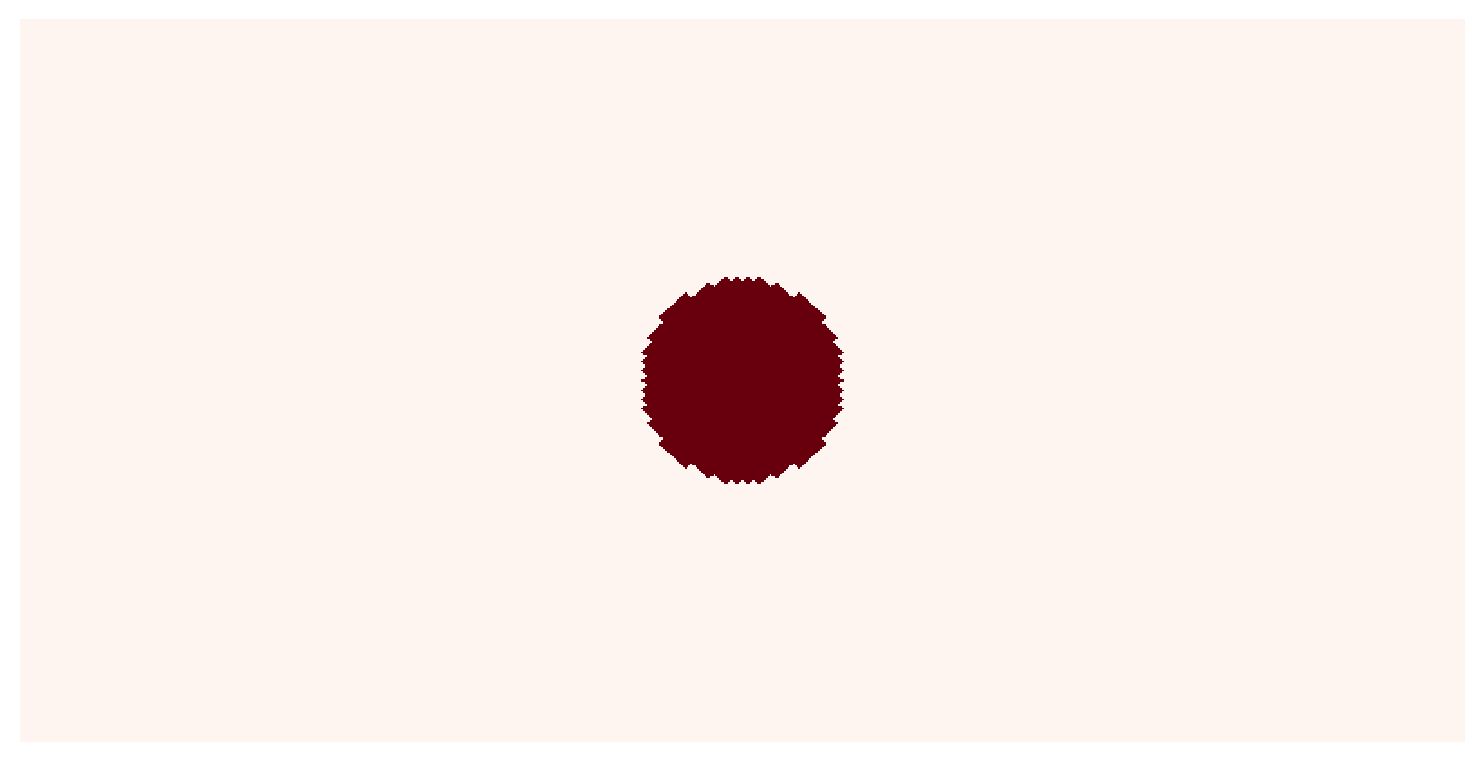

In [49]:
# Define observed wavelength grid properties
lammin1 = 2.41 
lammax1 = 3.98 
dlam1 = 0.18

# Construct wavelength grid
lamlo, dlamlo = gen_lightcurves.construct_lam(lammin1, lammax1, dlam=dlam1)
Nlamlo = len(lamlo)

# Set HealPy pixel numbers
Npix = spaxels.shape[0]

# Define empty 2d array for spaxels
spec2d = np.zeros((Npix, Nlamlo))

# Loop over pixels filling with spectra
for i in range(Npix):
    
    # Degrade the spectra to lower resolution
    spec2d[i,:] = gen_lightcurves.downbin_spec(spaxels[i, :], lamhr, lamlo, dlam = dlamlo)

# Let's just make a crude plot of our map
waveInd = 0
x = hp.cartview(spec2d[:,waveInd], title="", cbar=False, cmap=plt.cm.Reds, lonra=[-180,180], latra=[-90,90], notext=False, 
            return_projected_map = True)



## Use `starry` to make eclipse lightcurves

In [50]:
# Generate the multi-wavelength eclipse lightcurves using starry
time, lam, dlam, lcurves = gen_lightcurves.create_lightcurves_with_starry(lamhr, spaxels, 
                                                                          save_output=True, 
                                                                          save_tag="example1",
                                                                          plot_lightcurves = False, 
                                                                          plot_diagnostic = False, 
                                                                          plot_points_on_map_spec=False)

Saved file with tag = 'example1'


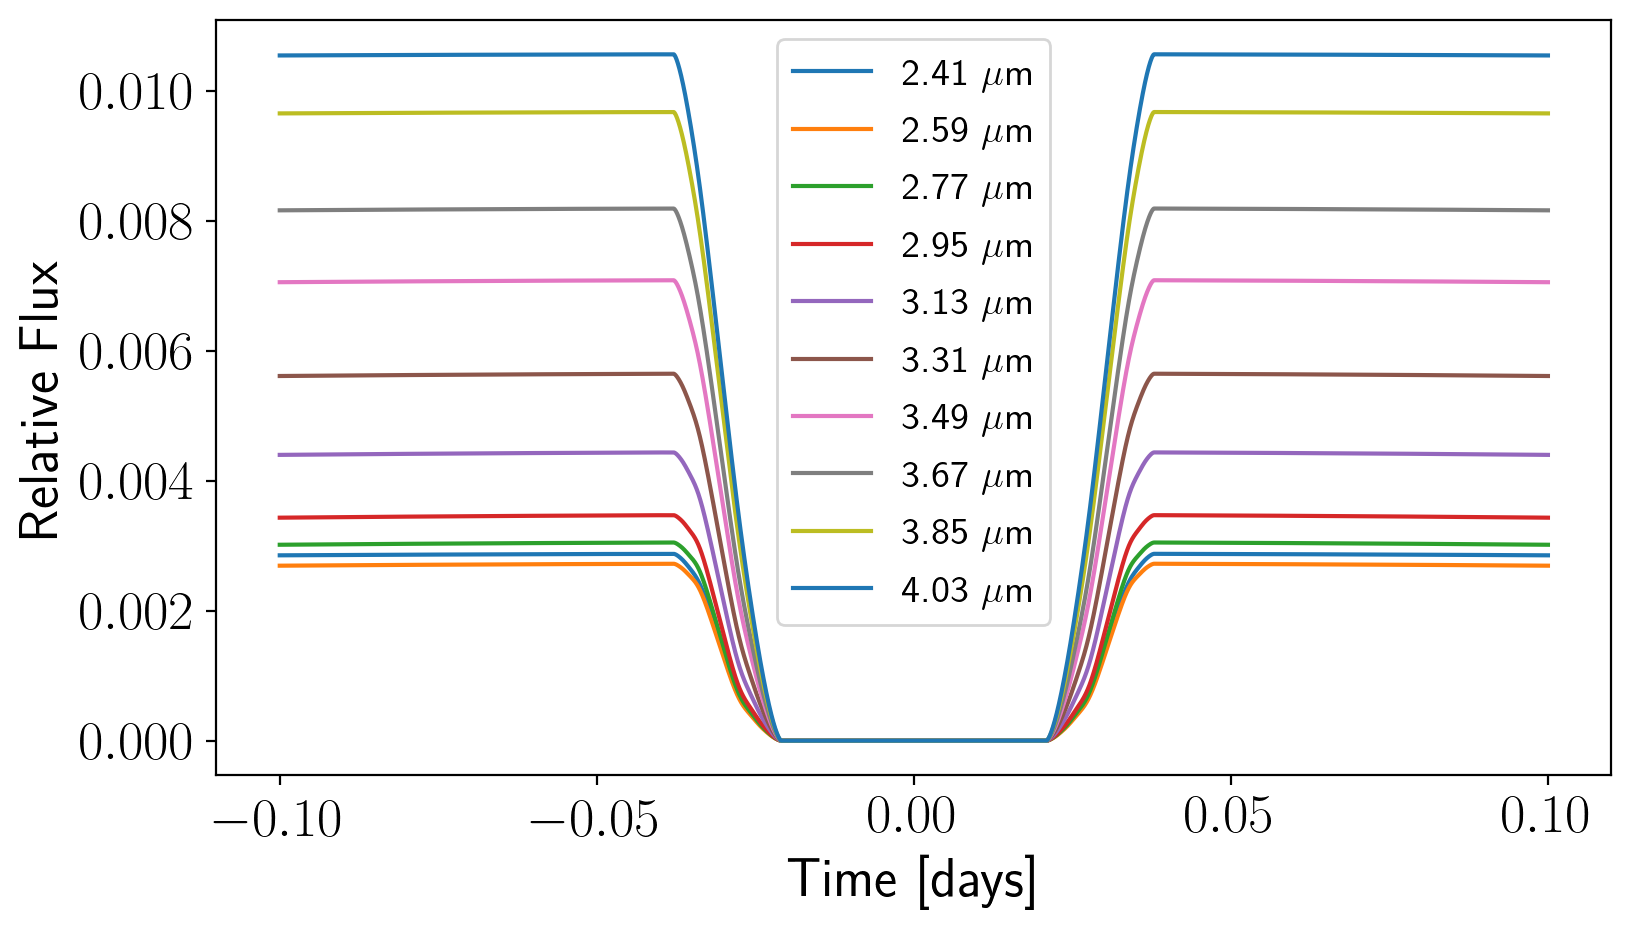

In [51]:
# Plot the lightcurves
fig, ax = plt.subplots(1, figsize=(9, 5))
ax.set_xlabel('Time [days]')
ax.set_ylabel('Relative Flux')
for i in range(Nlamlo):
    # Subtract off minimum (which is the bottom of the eclipse) to look
    # like traditional form
    lc = lcurves[:,i] - np.min(lcurves[:,i])
    ax.plot(time, lc, c = "C%i" %(i%9), label = r"%.2f $\mu$m" %(lamlo[i]))
ax.legend(ncol = 1, fontsize = 14);

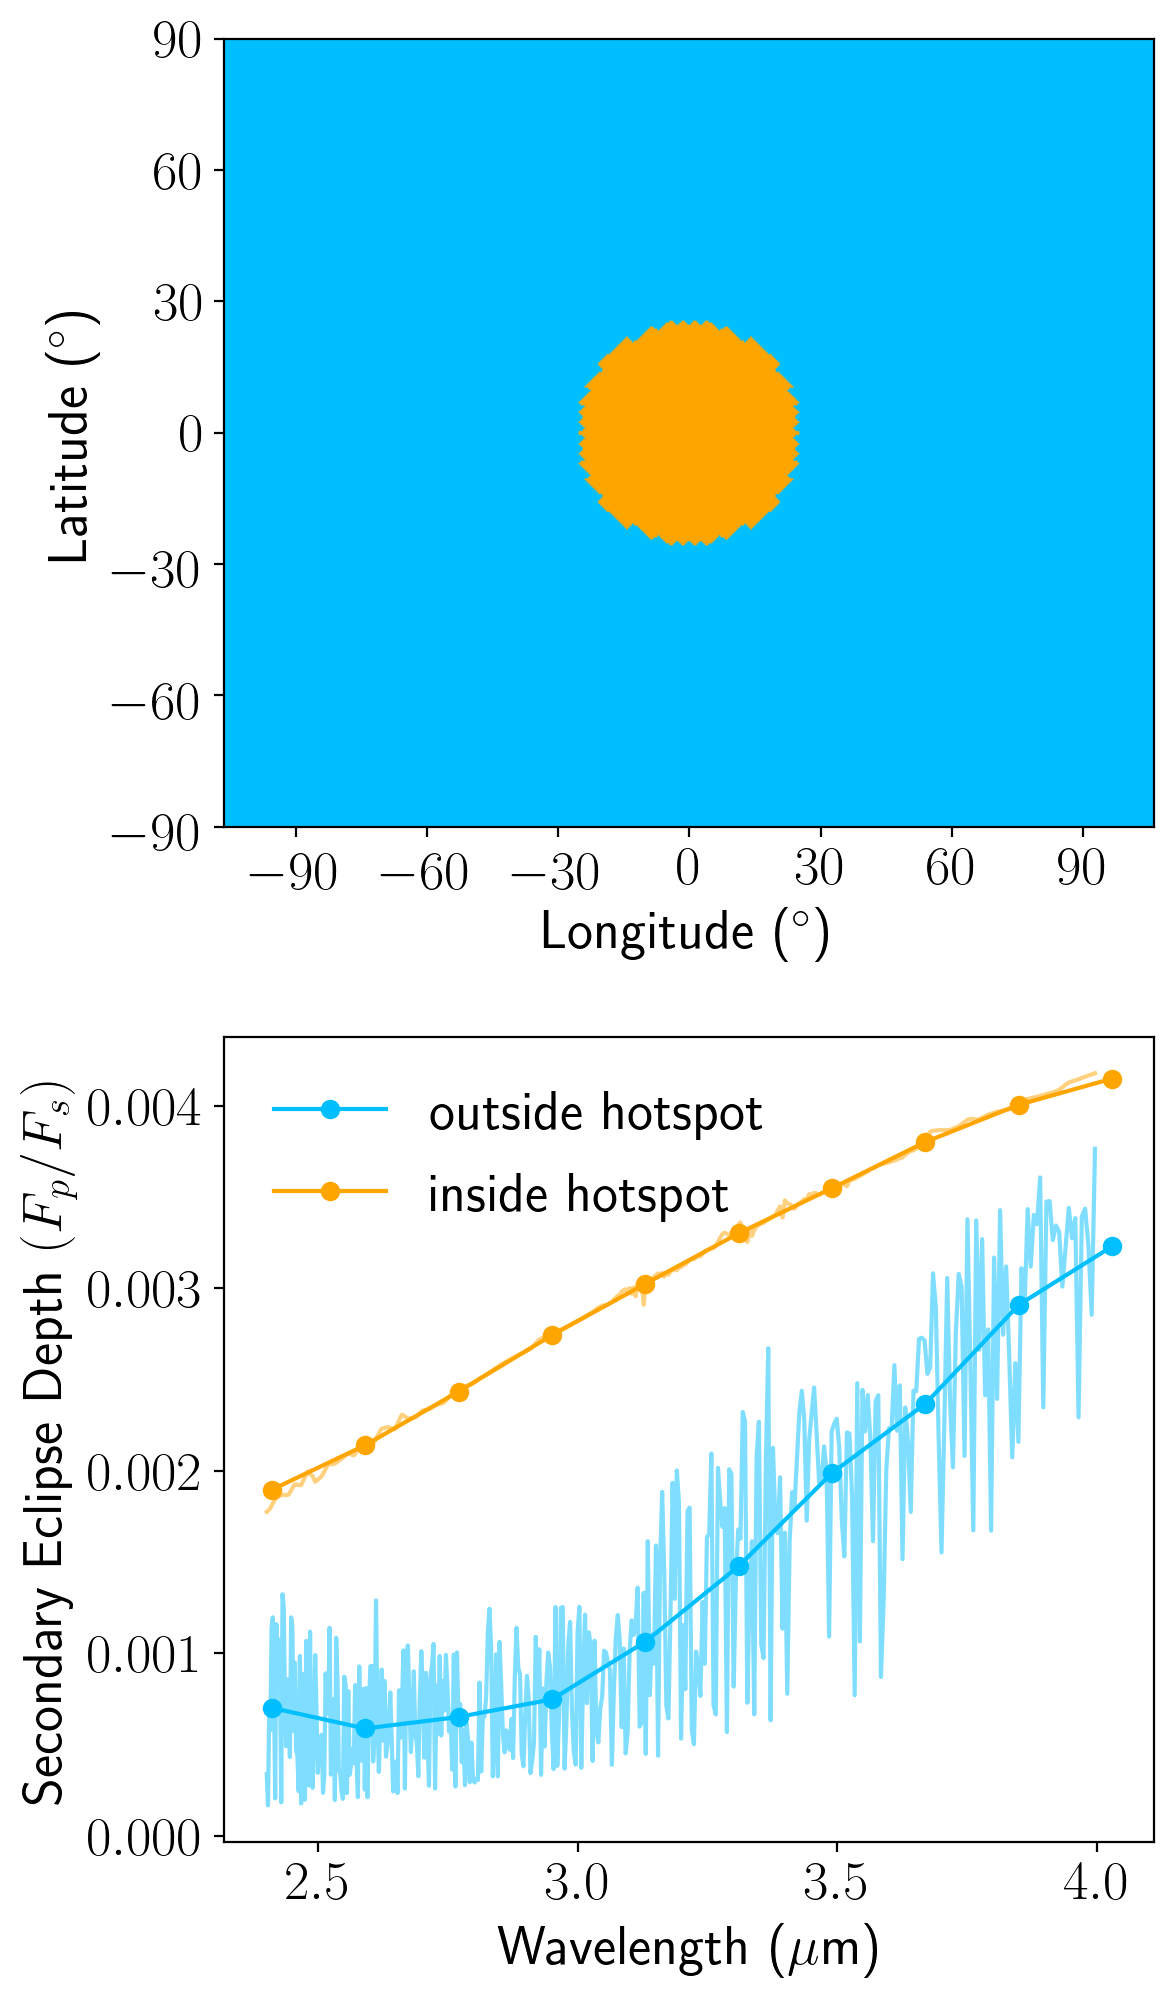

In [52]:
# Create a custom color map to visually connect map and spectra
cm = plot_utils.create_linear_colormap(c1 = "deepskyblue", c2 = "orange")

# Specify exact viewing geometry
extent=(np.max(time)-np.min(time))/2.21857567+180./360.
data_extent = (-180, 180, -90, 90)
full_extent = np.array([-extent/2.*360.,extent/2.*360.,-90.,90.])

# Create figure
fig, ax = plt.subplots(2,1, figsize = (6, 12), gridspec_kw={"hspace" : 0.25})

# Upper panel 
ax[0].imshow(x, origin="lower", extent = data_extent, cmap=cm, aspect="equal")
ax[0].set_ylabel("Latitude ($^{\circ}$)")
ax[0].set_xlabel("Longitude ($^{\circ}$)")
ax[0].set_xlim(full_extent[0], full_extent[1])
ax[0].set_ylim(full_extent[2], full_extent[3])
ax[0].set_yticks([-90, -60, -30, 0, 30, 60, 90])
ax[0].set_xticks([-90, -60, -30, 0, 30, 60, 90])

# Lower panel
ax[1].set_xlabel("Wavelength ($\mu$m)")
ax[1].set_ylabel("Secondary Eclipse Depth $(F_p / F_s)$")
ax[1].plot(lamhr, spaxels[imin,:], color = "deepskyblue", alpha = 0.5)
ax[1].plot(lamlo, spec2d[imin,:], "-o", color = "deepskyblue", label="outside hotspot")
ax[1].plot(lamhr, spaxels[imax,:], color = "orange", alpha = 0.5)
ax[1].plot(lamlo, spec2d[imax,:], "-o", color = "orange", label="inside hotspot")
ax[1].legend(framealpha = 0.0);